In [1108]:
import pandas as pd
import datetime
from sklearn.neural_network import MLPClassifier
import random
import torch
from net import gtnet
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [1109]:
model = torch.load(f'/mnt/results/model/model_all_pop_edema_0_advweight_1.7_GNN_advTrue.pt')



In [1110]:
model.eval()
for p in model.parameters():
    print(p.nelement())

128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
256
16
256
16
256
16
256
16
256
16
92672
32
86528
32
74240
32
49664
32
512
32
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
16
16
760
760
1600
40
1600
40
224
7
7
1
5984
32
512
32


In [1111]:
model.idx

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18], device='cuda:0')

In [1112]:
adj = model.gc(model.idx).cpu().detach().numpy()

In [1113]:
model.gc(model.idx).shape

torch.Size([19, 19])

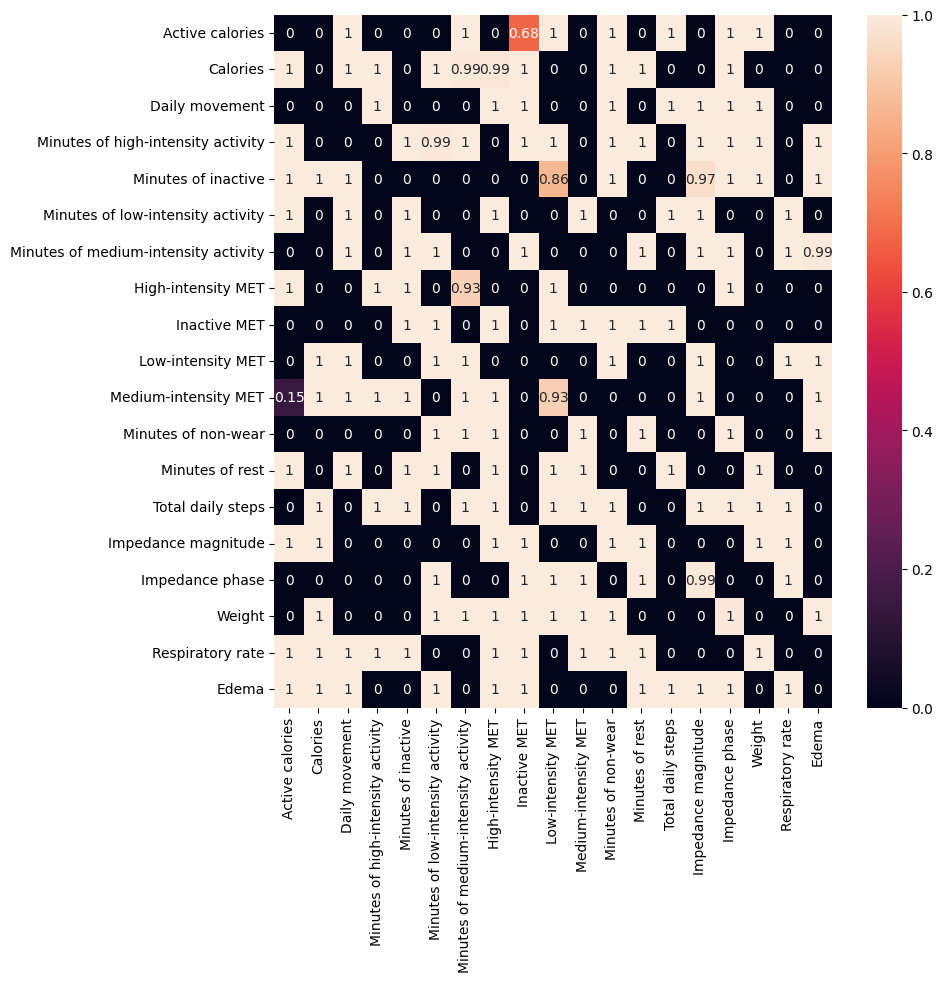

In [1114]:
features = ['Active calories','Calories','Daily movement','Minutes of high-intensity activity','Minutes of inactive','Minutes of low-intensity activity','Minutes of medium-intensity activity','High-intensity MET','Inactive MET','Low-intensity MET','Medium-intensity MET','Minutes of non-wear','Minutes of rest','Total daily steps','Impedance magnitude','Impedance phase','Weight','Respiratory rate','Edema']
def analysis_result(mat, features):
    cm_df = pd.DataFrame(mat,   
                    index = features, 
                    columns = features)

    #Plotting the confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm_df, annot=True)
    plt.savefig('/mnt/results/plots/adj.svg')
    plt.show()
analysis_result(adj, features)

In [1115]:
import argparse
import math
import time

import torch
import torch.nn as nn
from net import gtnet
import numpy as np
import importlib

from util import *
from trainer import Optim
from sequence_dataset import SequenceDataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader 
from model import LSTMClassifier

In [1116]:
from util import *
list_users_above_criteria = [53, 55, 137, 159, 410, 581, 622, 987, 1426]
train_df_lst = []
val_df_lst = []
train_dataset_lst = []
val_dataset_lst = []
device = torch.device("cuda:0")
task_name = 'edema_pred'

train_user_label = []
val_user_label = []

for u in list_users_above_criteria:
    file_name = f'/mnt/results/{task_name}/user_{u}_{task_name}_hyperimpute.csv'
    curr_all_data = np.loadtxt(file_name, delimiter=',')
    num_all_data, _ = curr_all_data.shape
    curr_train_data = curr_all_data[:int(round(num_all_data * 0.8)), :]
    curr_val_data = curr_all_data[int(round(num_all_data * 0.8)):, :]
    train_df_lst.append(curr_train_data)
    val_df_lst.append(curr_val_data)

# normalization
normalized_train_df_lst, min_value_lst, max_value_lst = min_max_normalization(train_df_lst)
normalized_val_df_lst, _, _ = min_max_normalization(val_df_lst, min_value_lst=min_value_lst, max_value_lst=max_value_lst)

# create sequential datasets
for i, curr_train_data in enumerate(normalized_train_df_lst):
    curr_train_dataset = SequenceDataset(curr_train_data, 1, 7, device,i)
    train_dataset_lst.append(curr_train_dataset)
    train_user_label.extend([list_users_above_criteria[i]] * len(curr_train_dataset))
    
for i, curr_val_data in enumerate(normalized_val_df_lst):
    curr_val_dataset = SequenceDataset(curr_val_data, 1, 7, device,i)
    val_dataset_lst.append(curr_val_dataset)
    val_user_label.extend([list_users_above_criteria[i]] * len(curr_val_dataset))


all_user_label = train_user_label + val_user_label

# aggregate them
aggregated_train_dataset = ConcatDataset(train_dataset_lst)
aggregated_val_dataset = ConcatDataset(val_dataset_lst)
all_dataset = ConcatDataset([aggregated_train_dataset, aggregated_val_dataset])
train_dataloader = DataLoader(aggregated_train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(aggregated_val_dataset, batch_size=32, shuffle=False)
dataloader = DataLoader(all_dataset, batch_size=32, shuffle=False)
num_train_data = len(aggregated_train_dataset)
num_val_data = len(aggregated_val_dataset)
num_train_data

498

In [1117]:
num_val_data

74

In [1118]:
from typing import Dict, Iterable, Callable

class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features

In [1119]:
# args = {'data': '/mnt/results/user_1431_activity_bodyport_hyperimpute.csv', 'log_interval': 2000, 'save': '/mnt/results/model/model_all_pop_edema_0_GNN.pt', 'optim': 'adam', 'L1Loss': True, 'normalize': 0, 'device': 'cuda:0', 'gcn_true': True, 'buildA_true': True, 'gcn_depth': 2, 'num_nodes': 21, 'dropout': 0.3, 'subgraph_size': 21, 'node_dim': 40, 'dilation_exponential': 2, 'conv_channels': 16, 'residual_channels': 16, 'skip_channels': 32, 'end_channels': 64, 'in_dim': 1, 'seq_in_len': 7, 'seq_out_len': 1, 'horizon': 1, 'layers': 5, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 1e-05, 'clip': 5, 'propalpha': 0.05, 'tanhalpha': 3, 'epochs': 50, 'num_split': 1, 'step_size': 100}
# model = gtnet(args['gcn_true'], args['buildA_true'], args['gcn_depth'], args['num_nodes'],
#                     device, dropout=args['dropout'], subgraph_size=args['subgraph_size'],
#                     node_dim=args['node_dim'], dilation_exponential=args['dilation_exponential'],
#                     conv_channels=args['conv_channels'], residual_channels=args['residual_channels'],
#                     skip_channels=args['skip_channels'], end_channels= args['end_channels'],
#                     seq_length=args['seq_in_len'], in_dim=args['in_dim'], out_dim=args['seq_out_len'],
#                     layers=args['layers'], propalpha=args['propalpha'], tanhalpha=args['tanhalpha'], layer_norm_affline=False)
# torch.load(f'/mnt/results/model/model_all_pop_edema_0_GNN.pt')

In [1120]:
gtnet_features = FeatureExtractor(model, layers=["end_conv_1"])
output_lst = []
edema_lst = []
input_lst = []
for batch_data in dataloader:
    X = batch_data['X'].to(device)
    Y = batch_data['Y'].to(device)
    feature_size = X.shape[-1]

    X = torch.unsqueeze(X,dim=1)
    X = X.transpose(2,3)
    edema_label = Y[:, -1].unsqueeze(-1).cpu().detach().numpy()
    edema_lst.append(edema_label)
    
    with torch.no_grad():
        output = gtnet_features(X)['end_conv_1']
        print(output.shape)
        output_lst.append(output.squeeze(-1).view(output.shape[0], -1).cpu().detach().numpy())
        input_lst.append(X.squeeze(-1).reshape(X.shape[0], -1).cpu().detach().numpy())
    

torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([32, 7, 19, 1])
torch.Size([28, 7, 19, 1])


In [1121]:
edema_lst = np.concatenate(edema_lst)


In [1122]:

all_embeddings = np.concatenate(output_lst, axis=0)
# all_embeddings = np.concatenate(input_lst, axis=0)

In [1123]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
    # tsne_results = tsne.fit_transform(pca_result)
tsne_results = tsne.fit_transform(all_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 572 samples in 0.001s...
[t-SNE] Computed neighbors for 572 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 572 / 572
[t-SNE] Mean sigma: 0.030296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.454651
[t-SNE] KL divergence after 300 iterations: 0.697421


<AxesSubplot:xlabel='X', ylabel='Y'>

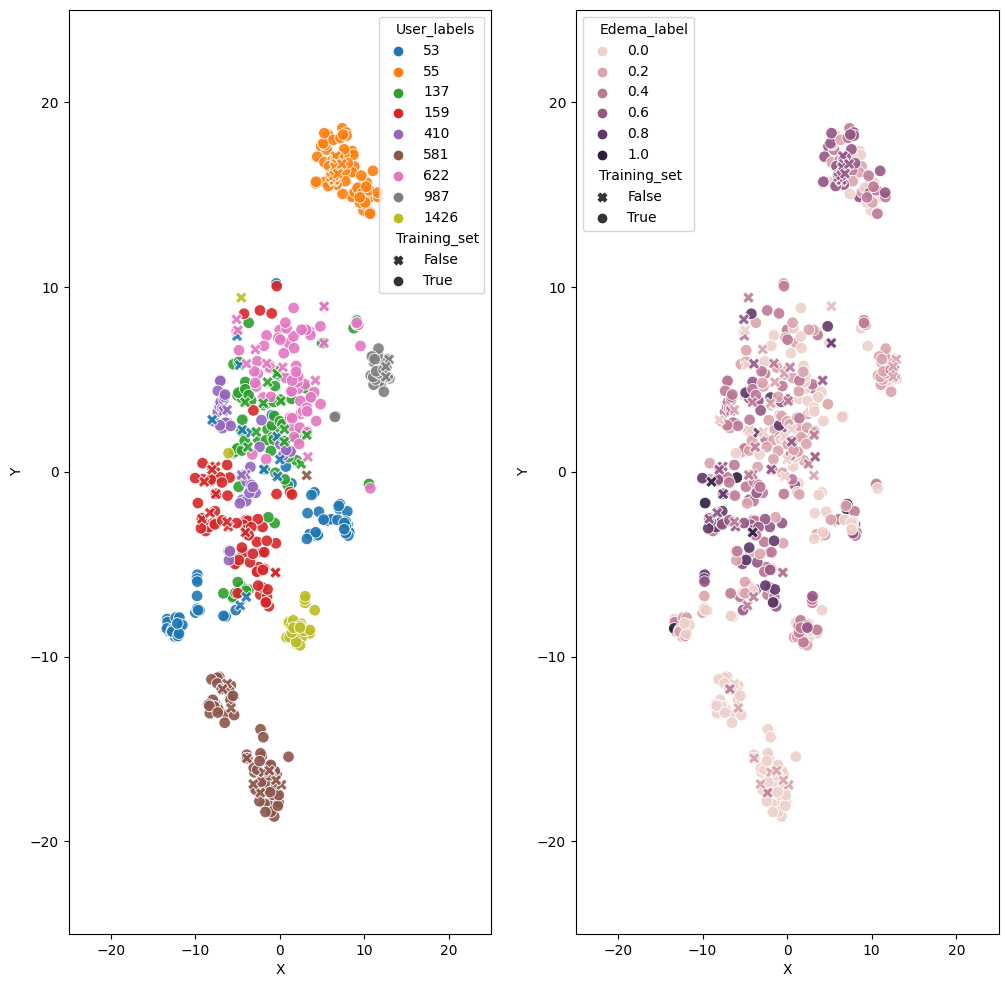

In [1124]:
df_tsne = pd.DataFrame(tsne_results, columns=["X", "Y"])

df_tsne["User_labels"] = all_user_label
df_tsne["User_labels"] = df_tsne["User_labels"].apply(lambda i: str(i))

df_tsne["Training_set"] = [True] * num_train_data + [False] * num_val_data
markers_dict = {
    True: 'o',
    False: 'X',
}
df_tsne["Edema_label"] = edema_lst
fig, axs = plt.subplots(ncols=2, figsize=(12, 12))
# plt.figure(figsize=(16,16))
axs[0].set(ylim=(-25, 25))
axs[0].set(xlim=(-25, 25))
axs[1].set(ylim=(-25, 25))
axs[1].set(xlim=(-25, 25))
sns.scatterplot(
    x="X", y="Y",
    hue="User_labels",
    style="Training_set",
    data=df_tsne,
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict,
    ax=axs[0]
)

# plt.savefig('/mnt/results/plots/embedding_no_labels.svg')


sns.scatterplot(
    x="X", y="Y",
    hue="Edema_label",
    style="Training_set",
    data=df_tsne,
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict,
    ax=axs[1]
)

In [1125]:

plt.savefig('/mnt/results/plots/embedding_with_labels.svg')

<Figure size 640x480 with 0 Axes>